In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from luxai_s2.env import LuxAI_S2
import matplotlib.pyplot as plt
import numpy as np
from adl.debugger import Debugger
from agent import Agent
from lux.kit import obs_to_game_state, GameState, EnvConfig
from luxai_s2.utils import animate
from lux.utils import direction_to, my_turn_to_place_factory
from adl.kit import animate, interact

In [18]:
env = LuxAI_S2() # create the environment object
obs = env.reset(seed=41) # resets an environment with a seed

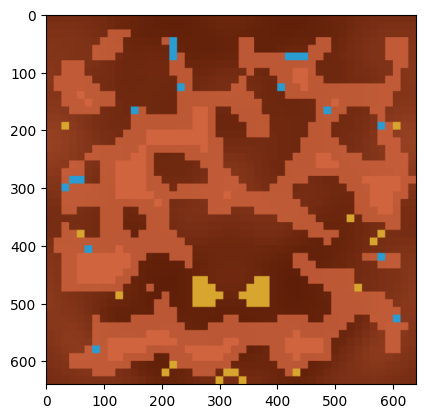

In [19]:
# visualize the environment so far with rgb_array to get a quick look at the map
# dark orange - high rubble, light orange - low rubble
# blue = ice, yellow = ore
img = env.render("rgb_array", width=640, height=640)
plt.imshow(img)

In [20]:
# for seed in range(41, 45):
#     obs = env.reset(seed=seed) # resets an environment with a seed
#     img = env.render("rgb_array", width=640, height=640)
#     plt.figure()
#     plt.imshow(img)

In [21]:
game_state = obs_to_game_state(0, env.state.env_cfg, obs["player_0"])

In [22]:

from sklearn import metrics
from scipy.spatial.distance import cdist

In [23]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans

In [50]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

X = np.argwhere(game_state.board.ice == 1)

maxFactories = 8
maxK = min(int(np.sum(game_state.board.ice)), maxFactories)
K = range(1, maxK+1)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init="auto").fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_



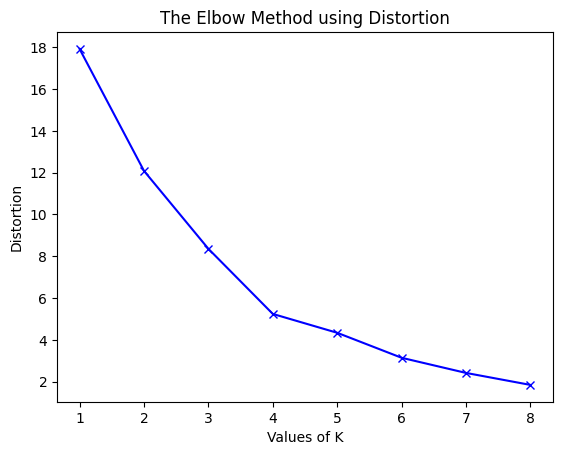

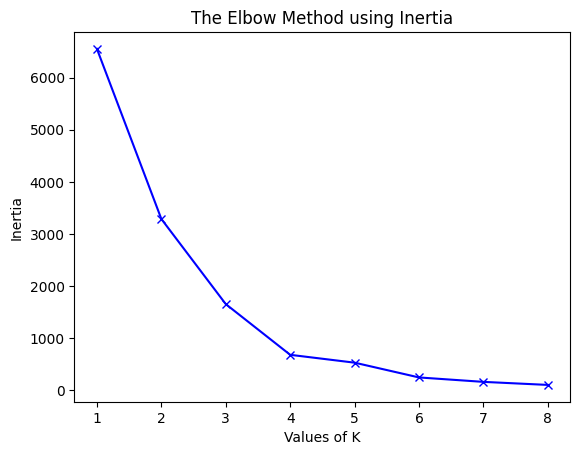

In [51]:
# for key, val in mapping1.items():
#     print(f'{key} : {val}')
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

# for key, val in mapping2.items():
#     print(f'{key} : {val}')
    
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [63]:
from typing import *
from collections import defaultdict, Counter
def getResourceCluster(resourceMap: np.ndarray, interCluserDistance: int, maxFactories: int) -> Dict[np.ndarray, int]:
    """
    we return clusters where distortion <= interCluserDistance
    """

    clusterMembership = defaultdict()
    currentClusters = [] # list of lists

    distortions = []
    distMapping = {}
    models = {}

    X = np.argwhere(resourceMap == 1)

    maxK = min(int(np.sum(resourceMap)), maxFactories)
    K = range(1, maxK+1)

    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k, n_init="auto").fit(X)
        kmeanModel.fit(X)
        models[k] = kmeanModel

        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / X.shape[0])

        distMapping[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                    'euclidean'), axis=1)) / X.shape[0]

    bestK = None
    for key, val in distMapping.items():
        # self.logger.info(f'{key} : {val}')
        print(f'{key} : {val}')

        bestK = key
        if val < interCluserDistance:
            break

    # self.logger.info(f'best K : {bestK}')
    print(f'best K : {bestK}')

    # now we need the centers, and cluster sizes
    bestModel = models[bestK]
    centers = bestModel.cluster_centers_

    # now size of each cluster
    clutersSizes = defaultdict()
    membership = bestModel.predict(X)
    centerIdxFreq = Counter(membership)
    print("centerIdxFreq", centerIdxFreq)

    for centerIdx, n in centerIdxFreq.items():
        center = tuple(centers[centerIdx])
        clutersSizes[center] = n




    # return
    # cluster centers, # of resources in each cluster.
    return clutersSizes

In [73]:
clusterSizes = getResourceCluster(game_state.board.ice, 6, game_state.maxFactoriesPerPlayer * 2)
clusterSizes

1 : 17.920117300308547
2 : 11.613397912127963
3 : 9.994661450519978
4 : 5.2418040592409785
best K : 4
centerIdxFreq Counter({0: 6, 1: 5, 2: 5, 3: 2})


defaultdict(None,
            {(4.0, 27.4): 5,
             (15.2, 6.6): 5,
             (34.166666666666664, 8.333333333333332): 6,
             (44.0, 35.0): 2})

(4.0, 27.4) 52 356
slice(46, 58, None) slice(350, 362, None)
(15.2, 6.6) 197 85
slice(191, 203, None) slice(79, 91, None)
(34.166666666666664, 8.333333333333332) 444 108
slice(438, 450, None) slice(102, 114, None)
(44.0, 35.0) 572 455
slice(566, 578, None) slice(449, 461, None)


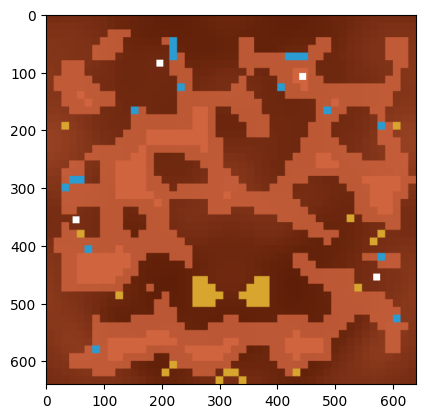

In [88]:
from adl.utils import Utils
img = env.render("rgb_array", width=640, height=640)
Utils.addClustersToImg(img, clusterSizes)
plt.imshow(img)

In [66]:
type(img)

numpy.ndarray

In [68]:
img.shape

(640, 640, 3)